# Predicting Heart Disease Using Machine Learning

This notebook looks into using various machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not someone has heart disease based on their medical attributes.

## Data Attribute Information

* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
    anything above 130-140 is typically cause for concern
* chol - serum cholestoral in mg/dl
    serum = LDL + HDL + .2 * triglycerides
    above 200 is cause for concern
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    '>126' mg/dL signals diabetes
* restecg - resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
        can range from mild symptoms to severe problems
        signals non-normal heart beat
    * 2: Possible or definite left ventricular hypertrophy
        Enlarged heart's main pumping chamber
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
    looks at stress of heart during excercise
    unhealthy heart will stress more
* slope - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
* ca - number of major vessels (0-3) colored by flourosopy
    colored vessel means the doctor can see the blood passing through
    the more blood movement the better (no clots)
* thal - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising
* target - have disease or not (1=yes, 0=no) (= the predicted attribute)

In [1]:
# Importing the tools that we'll use
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-disease-uci/heart.csv


In [2]:
df = pd.read_csv('/kaggle/input/heart-disease-uci/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

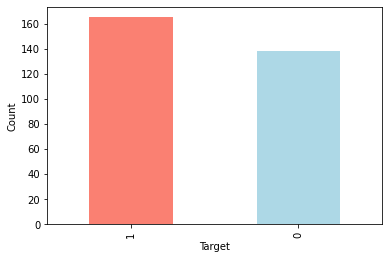

In [4]:
df['target'].value_counts().plot(kind='bar', color=['salmon', 'lightblue'], xlabel='Target', ylabel='Count');

In [5]:
# Percentage of patients that have heart disease
df['target'].value_counts(normalize=True) * 100

1    54.455446
0    45.544554
Name: target, dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
# Check to see if we have any missing values
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [8]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


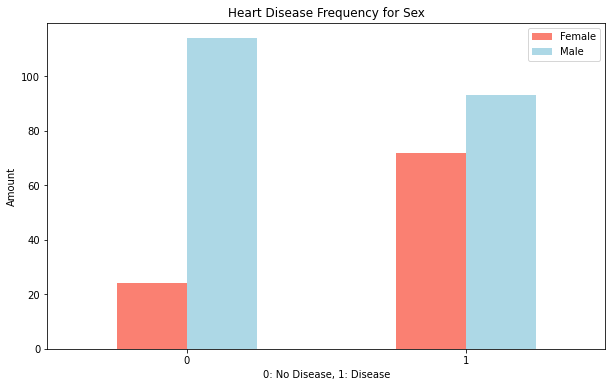

In [9]:
# Heart Disease Frequency for Sex
pd.crosstab(df['target'], df['sex']).plot(kind='bar', figsize=(10, 6), color=['salmon', 'lightblue'])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('0: No Disease, 1: Disease')
plt.ylabel('Amount')
plt.legend(['Female', 'Male'])
plt.xticks(rotation=0)
plt.show()

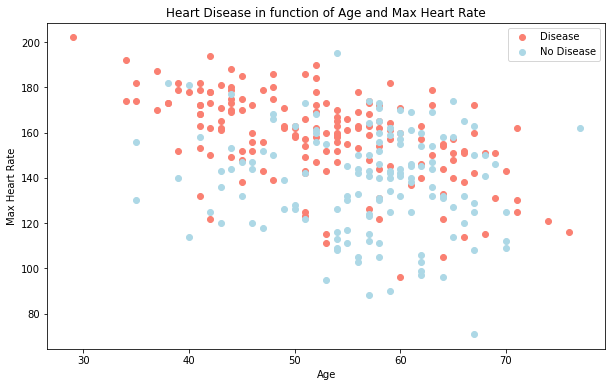

In [10]:
plt.figure(figsize=(10,6))

# Positve examples
plt.scatter(df.age[df.target==1], 
            df.thalach[df.target==1], 
            c="salmon")

# Negative examples
plt.scatter(df.age[df.target==0], 
            df.thalach[df.target==0], 
            c="lightblue")

plt.title("Heart Disease in function of Age and Max Heart Rate")
plt.xlabel("Age")
plt.legend(["Disease", "No Disease"])
plt.ylabel("Max Heart Rate")
plt.show()

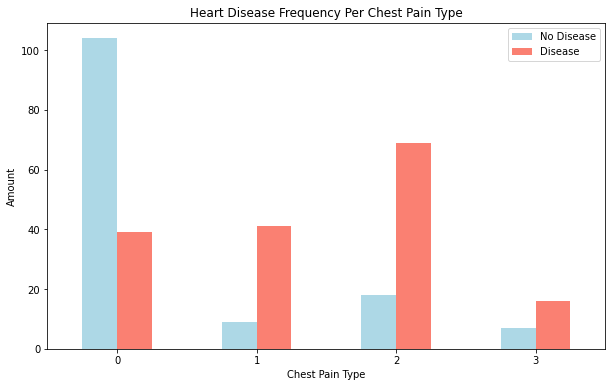

In [11]:
pd.crosstab(df.cp, df.target).plot(kind="bar", figsize=(10, 6), color=["lightblue", "salmon"]);
plt.title("Heart Disease Frequency Per Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Amount")
plt.legend(["No Disease", "Disease"])
plt.xticks(rotation=0);

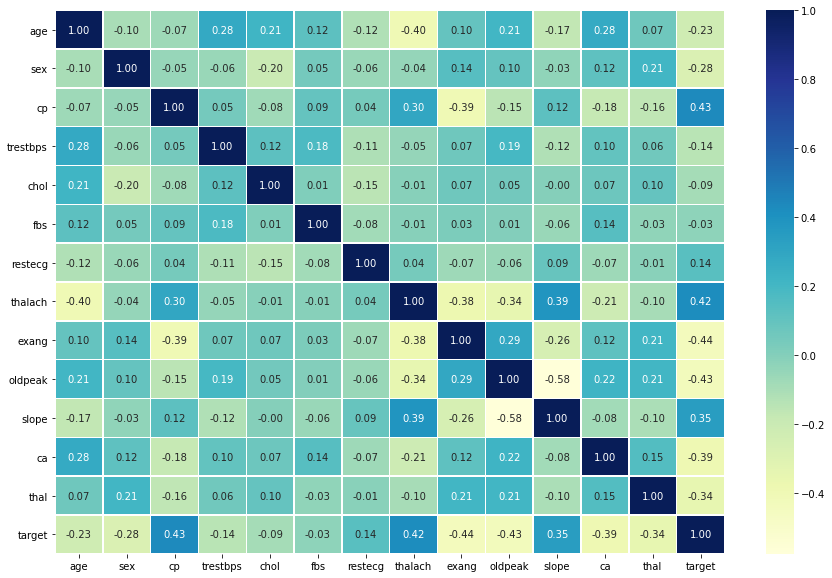

In [12]:
# Correlation Matrix
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu");

## Modeling

In [13]:
# Turning Categorical variables into Dummy variables
cp = pd.get_dummies(df['cp'], prefix = "cp")
thal = pd.get_dummies(df['thal'], prefix = "thal")
slope = pd.get_dummies(df['slope'], prefix = "slope")
restecg = pd.get_dummies(df['restecg'], prefix = "restecg")
frames = [df, cp, thal, slope, restecg]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope', 'restecg'])
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,...,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2,restecg_0,restecg_1,restecg_2
0,63,1,145,233,1,150,0,2.3,0,1,...,0,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,1,...,0,0,1,0,1,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,1,...,0,0,1,0,0,0,1,1,0,0
3,56,1,120,236,0,178,0,0.8,0,1,...,0,0,1,0,0,0,1,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,...,0,0,1,0,0,0,1,0,1,0


In [14]:
# Splitting the data into X and y and to train and test 
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((242, 23), (61, 23), (242,), (61,))

In [16]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluatest given machine learning models. 
    models: a dict of different Scikit-Learn machine learning models
    X_train: training data (no labels)
    X_test: testing data (no labels)
    y_train: training labels
    y_test: testing labels
    """
    # Set random seed 
    np.random.seed(42)
    
    # Make a dictionary to keep model scores
    model_scores = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [17]:
model_scores = fit_and_score(models=models, 
                             X_train=X_train, 
                             X_test=X_test, 
                             y_train=y_train, 
                             y_test=y_test)
model_scores

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'Logistic Regression': 0.8688524590163934,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8852459016393442}

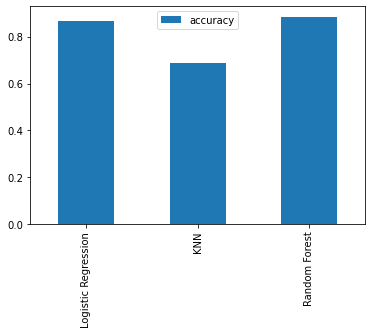

In [18]:
# Model comparison
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

### Hyperparameter tuning and cross-validation

In [19]:
# Let's tuning KNeighborsClassifier

train_scores = []
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1, 21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors 
for i in neighbors:
    knn.set_params(n_neighbors=i)
    # Fit the algorithm
    knn.fit(X_train, y_train)
    # Update the training scores list
    train_scores.append(knn.score(X_train, y_train))
    # Update the test scores list 
    test_scores.append(knn.score(X_test, y_test))

Maximum KNN score on the test data: 75.41%


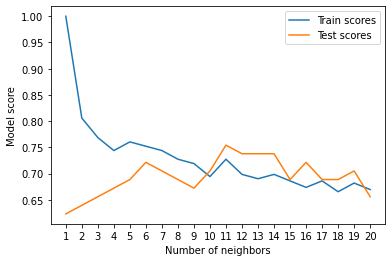

In [20]:
# Visualizing the KNN Scores
plt.plot(neighbors, train_scores, label="Train scores")
plt.plot(neighbors, test_scores, label="Test scores")
plt.xticks(np.arange(1,21,1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%");

### Hyperparameter Tuning - RandomizedSearchCV

In [21]:
# Hyperparameter grid for LogisticRegression
logReg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Hyperparameter grid for RandomForestClassifier
randomForest_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10], 
           "min_samples_split": np.arange(2, 20, 2), 
           "min_samples_leaf": np.arange(1, 20, 2)}

In [22]:
# Tune LogisticsRegression
np.random.seed(42)

# Setup random hyperparameter search for LogsiticRegression
rs_logReg = RandomizedSearchCV(LogisticRegression(), 
                                param_distributions=logReg_grid, 
                                cv=5, n_iter=20, 
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_logReg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [23]:
# Best parameters for LogisticRegression in RandomizedSearchCV
rs_logReg.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [24]:
# Score after RandomizedSearchCV Hyperparameter Tuning
rs_logReg.score(X_test, y_test)

0.9016393442622951

In [25]:
# Score before RandomizedSearchCV Hyperparameter Tuning
model_scores['Logistic Regression']

0.8688524590163934

In [26]:
# Tune RandomForestClassifier
np.random.seed(42)

# Setup randdom hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                           param_distributions=randomForest_grid, 
                           cv=5, 
                           n_iter=20, 
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [27]:
# Best Parameters for RandomForestClassifier in RandomizedSearchCV
rs_rf.best_params_

{'n_estimators': 210,
 'min_samples_split': 4,
 'min_samples_leaf': 19,
 'max_depth': 3}

In [28]:
# Score after RandomizedSearchCV Hyperparameter Tuning
rs_rf.score(X_test, y_test)

0.8852459016393442

In [29]:
# Score before RandomizedSearchCV Hyperparameter Tuning
model_scores['Random Forest']

0.8852459016393442

No change. 
Try to improve Logistic Regression even more with GridSearchCV

In [30]:
# Different hyperparameters for our LogisticRegression model
log_reg_grid = {"C": np.logspace(-4, 4, 30),
                "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(), 
                          param_grid=log_reg_grid, 
                          cv=5,  
                          verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [31]:
# Best parameters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [32]:
# Evaluating the grid search LogisticRegression model
gs_log_reg.score(X_test, y_test)

0.9016393442622951

In [33]:
# Make predictions with tuned model
y_preds = gs_log_reg.predict(X_test)
y_preds

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])

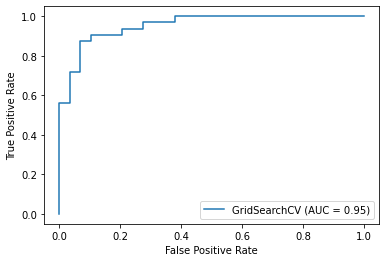

In [34]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(gs_log_reg, X_test, y_test);

Text(-1.5, 0.5, 'Predicted Label')

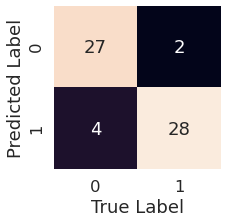

In [35]:
# Confusion Matrix
sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=(3, 3))
ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                    annot=True,
                    cbar=False)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")

In [36]:
# Classification Method
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



In [37]:
# Check best hyperparameters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [38]:
# Create a new classifier with best parameters
clf = LogisticRegression(C=0.20433597178569418, solver='liblinear')

In [39]:
# Cross-validated accuracy
cv_acc = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
cv_acc = np.mean(cv_acc)
cv_acc

0.8348633879781422

In [40]:
# Cross-validated precision
cv_precision = cross_val_score(clf, X, y, cv=5, scoring="precision")
cv_precision = np.mean(cv_precision)
cv_precision

0.8339445016864373

In [41]:
# Cross-validated recall
cv_recall = cross_val_score(clf, X, y, cv=5, scoring="recall")
cv_recall = np.mean(cv_recall)
cv_recall

0.8727272727272727

In [42]:
# Cross-validated f1-score
cv_f1 = cross_val_score(clf, X, y, cv=5, scoring="f1")
cv_f1 = np.mean(cv_f1)
cv_f1

0.8519786373047241

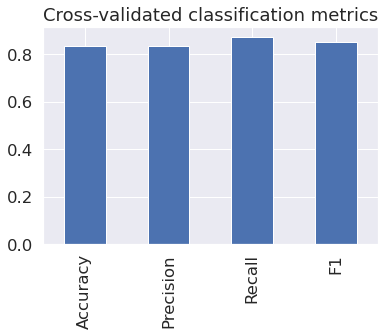

In [43]:
# Visualize the cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc, 
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1}, index=[0])

cv_metrics.T.plot.bar(title="Cross-validated classification metrics", 
                      legend=False);